# Functional Data Analysis

In the dataset for default payment in credit cards, we have three-time sequence variables. From the perspective of FDA, each sequence(curve) is a data-point or record and we can calculate statistical moments as the mean curve, std, curve distribution, ANOVA test, etc. We can do PCA, or even machine learning; predicting curves instead of single points.

# PCA

In this section, I am going to use functional PCA to transform sequence variables into scarlas and break temporal correlation. These scalars can represent: high, trend, and seasonality. 

In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from skfda import FDataGrid
from skfda.preprocessing.dim_reduction.projection import FPCA
from skfda.representation.basis import BSpline, Fourier, Monomial
# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot
# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

/home/lamahechag/anaconda3/envs/credit_card/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [6]:
# READ AND SPLIT THE DATA
df = pd.read_excel("default of credit card clients.xls", header=1)
# put ID as DataFrame INDEX
df.set_index('ID', inplace=True)
# train test split
X, y = df.drop('default payment next month', axis=1).values, df['default payment next month'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train = pd.DataFrame(X_train, columns=df.columns[:-1])
X_test = pd.DataFrame(X_test, columns=df.columns[:-1])

In [7]:
# build list names for each time variable
pay = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
bill_amt = [f'BILL_AMT{n}' for n in range(1,7)]
pay_amt = [f'PAY_AMT{n}' for n in range(1,7)]
time_series = [pay, bill_amt, pay_amt]
train_aux = X_train.drop(pay+bill_amt+pay_amt, axis=1).values
test_aux = X_test.drop(pay+bill_amt+pay_amt, axis=1).values

In [8]:
# CALCUATE PCA SCORES AND CONCATENATE TO WHOLE DATA.
for cols in time_series:
    #transform each sequence into a functional object
    fd_train = FDataGrid(X_train[cols].values, [1,2,3,4,5,6],
                   dataset_name='repayment',
                   argument_names=['t'],
                   coordinate_names=['x(t)'])

    fd_test = FDataGrid(X_test[cols].values, [1,2,3,4,5,6],
                   dataset_name='repayment',
                   argument_names=['t'],
                   coordinate_names=['x(t)'])
    # calculate principal curves(components)
    fpca_discretized = FPCA(n_components=3)
    fpca_discretized.fit(fd_train)
    print(cols)
    # calculate scores for each data-point
    train_aux = np.concatenate([train_aux, fpca_discretized.transform(fd_train)], axis=1)
    test_aux = np.concatenate([test_aux, fpca_discretized.transform(fd_test)], axis=1)
print(train_aux.shape[1])
print(test_aux.shape[1])

['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
14
14


# Train model with PCA transformation

In [18]:
from imblearn.ensemble import BalancedRandomForestClassifier
model = BalancedRandomForestClassifier(n_estimators=200, max_depth=15, bootstrap=True,
                                       min_samples_leaf=10, max_samples=0.7,
                                       min_samples_split=20, max_features=0.7,
                                       random_state=42, n_jobs=4, sampling_strategy=0.6)
model.fit(train_aux, y_train)
y_pred = model.predict(train_aux)
print(classification_report(y_train, y_pred))
y_pred = model.predict(test_aux)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90     17491
           1       0.65      0.63      0.64      5009

    accuracy                           0.84     22500
   macro avg       0.77      0.77      0.77     22500
weighted avg       0.84      0.84      0.84     22500

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      5873
           1       0.54      0.51      0.52      1627

    accuracy                           0.80      7500
   macro avg       0.70      0.69      0.70      7500
weighted avg       0.79      0.80      0.80      7500



We can see no improvement with functional PCA, just 1% increase in recall, which can be a random increment in this metric.

Text(0.5, 1.0, '1-class Precision-Recall curve: ')

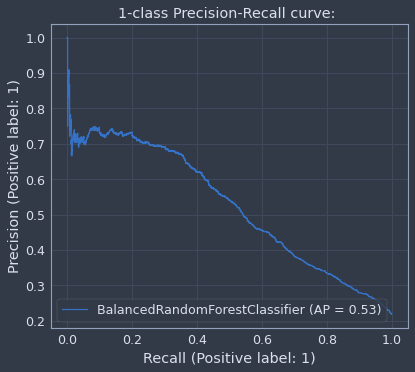

In [23]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

probas_pred = model.predict_proba(test_aux)[:, 1]
precision, recall, thresholds = precision_recall_curve(
    y_test, probas_pred)

disp = plot_precision_recall_curve(model, test_aux, y_test)
disp.ax_.set_title('1-class Precision-Recall curve: ')

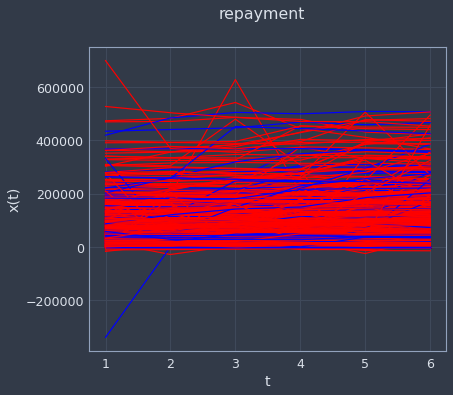

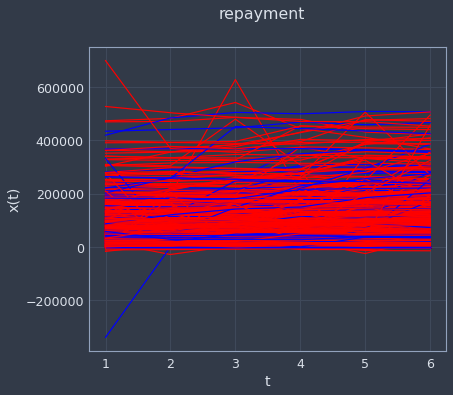

In [7]:
fd[:2000].plot(group=df['default payment next month'].values,
               group_colors=['red', 'blue'])

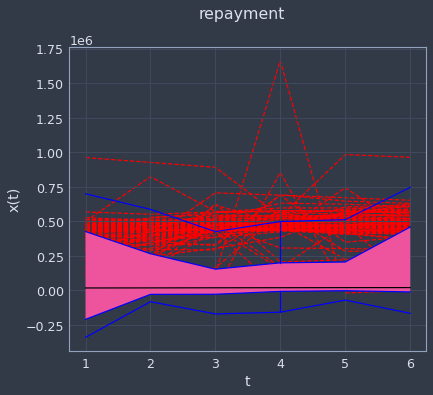

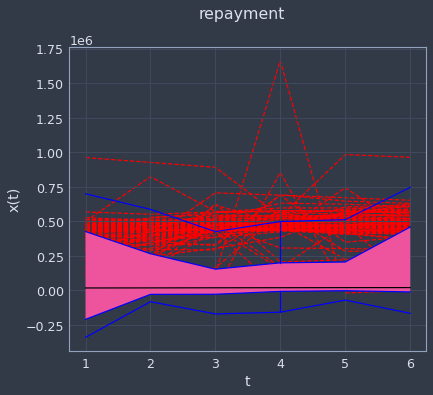

In [8]:
from skfda.exploratory.visualization import Boxplot
fdBoxplot = Boxplot(fd)
fdBoxplot.show_full_outliers = False
fdBoxplot.plot()